## Imports & GCP connection

In [40]:
from google.cloud import storage
from IPython.display import Audio
import os
import pandas as pd
import librosa
from itertools import islice
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Sequential, layers
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
storage_client = storage.Client()
bucket = storage_client.bucket('soundboard_data')

## Data loading, processing

### Youtube IDs, classes

In [ ]:
class_labels_df = pd.read_csv('../data/train_labels/audioset_ont_full.csv')
class_labels_df.head(20)

In [5]:
len(class_labels_df)

527

In [6]:
class_labels_df.class_1.value_counts()

Sounds of things                      166
Music                                 146
Human Sounds                           72
Animal                                 65
Source-ambiguous sounds                40
Channel environment and background     21
Natural Sounds                         17
Name: class_1, dtype: int64

### Make 'mid' key / class dictionaries

#### Display_name (lowest level)

In [7]:
label_dict_dn = pd.Series(class_labels_df.display_name.values,index=class_labels_df.mid).to_dict()

#### Class 1 (highest level)

In [8]:
label_dict = pd.Series(class_labels_df.class_1.values,index=class_labels_df.mid).to_dict()

In [9]:
def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))

In [10]:
n_label_keys = take(20, label_dict.items())
n_label_keys

[('/m/09x0r', 'Human Sounds'),
 ('/m/05zppz', 'Human Sounds'),
 ('/m/02zsn', 'Human Sounds'),
 ('/m/0ytgt', 'Human Sounds'),
 ('/m/01h8n0', 'Human Sounds'),
 ('/m/02qldy', 'Human Sounds'),
 ('/m/0261r1', 'Human Sounds'),
 ('/m/0brhx', 'Human Sounds'),
 ('/m/07p6fty', 'Human Sounds'),
 ('/m/07q4ntr', 'Human Sounds'),
 ('/m/07rwj3x', 'Human Sounds'),
 ('/m/07sr1lc', 'Human Sounds'),
 ('/m/04gy_2', 'Human Sounds'),
 ('/t/dd00135', 'Human Sounds'),
 ('/m/03qc9zr', 'Human Sounds'),
 ('/m/02rtxlg', 'Human Sounds'),
 ('/m/01j3sz', 'Human Sounds'),
 ('/t/dd00001', 'Human Sounds'),
 ('/m/07r660_', 'Human Sounds'),
 ('/m/07s04w4', 'Human Sounds')]

In [11]:
def get_class(label_id):
    return [(label_dict.get(label, '')) for label in label_id]

#### Make df with YTIDs, associated classes

In [12]:
train_labels_df = pd.read_csv('../data/train_labels/train.csv')
train_labels_df['tags_k'] = train_labels_df['positive_labels'].apply(lambda x: x.split(','))
train_labels_df.head(5)

,YTID,start_seconds,end_seconds,positive_labels,tags_k
0,--PJHxphWEs,30.0,40.0,"/m/09x0r,/t/dd00088","[/m/09x0r, /t/dd00088]"
1,--aE2O5G5WE,0.0,10.0,"/m/03fwl,/m/04rlf,/m/09x0r","[/m/03fwl, /m/04rlf, /m/09x0r]"
2,--aaILOrkII,200.0,210.0,"/m/032s66,/m/073cg4","[/m/032s66, /m/073cg4]"
3,--cB2ZVjpnA,30.0,40.0,/m/01y3hg,[/m/01y3hg]
4,--ekDLDTUXA,30.0,40.0,"/m/015lz1,/m/07pws3f","[/m/015lz1, /m/07pws3f]"


In [13]:
# Match keys with english labels, count tags
train_labels_df['tags'] = train_labels_df['tags_k'].apply(get_class)
train_labels_df['num_keys'] = train_labels_df['tags_k'].apply(lambda x: len(x))
train_labels_df['num_tags'] = train_labels_df['tags'].apply(lambda x: len(x))
train_labels_df

,YTID,start_seconds,end_seconds,positive_labels,tags_k,tags,num_keys,num_tags
0,--PJHxphWEs,30.0,40.0,"/m/09x0r,/t/dd00088","[/m/09x0r, /t/dd00088]","[Human Sounds, Sounds of things]",2,2
1,--aE2O5G5WE,0.0,10.0,"/m/03fwl,/m/04rlf,/m/09x0r","[/m/03fwl, /m/04rlf, /m/09x0r]","[Animal, Music, Human Sounds]",3,3
2,--aaILOrkII,200.0,210.0,"/m/032s66,/m/073cg4","[/m/032s66, /m/073cg4]","[Sounds of things, Sounds of things]",2,2
3,--cB2ZVjpnA,30.0,40.0,/m/01y3hg,[/m/01y3hg],[Sounds of things],1,1
4,--ekDLDTUXA,30.0,40.0,"/m/015lz1,/m/07pws3f","[/m/015lz1, /m/07pws3f]","[Human Sounds, Source-ambiguous sounds]",2,2
...,...,...,...,...,...,...,...,...
19639,zyqg4pYEioQ,20.0,30.0,"/m/09x0r,/m/0llzx","[/m/09x0r, /m/0llzx]","[Human Sounds, Sounds of things]",2,2
19640,zz0ddNfz0h0,30.0,40.0,"/m/012f08,/m/03cl9h,/m/07yv9,/m/0k4j","[/m/012f08, /m/03cl9h, /m/07yv9, /m/0k4j]","[Sounds of things, Sounds of things, Sounds of...",4,4
19641,zz8TGV83nkE,80.0,90.0,"/m/012f08,/m/02mk9,/m/04_sv,/m/07yv9","[/m/012f08, /m/02mk9, /m/04_sv, /m/07yv9]","[Sounds of things, Sounds of things, Sounds of...",4,4
19642,zzlK8KDqlr0,370.0,380.0,"/m/01m2v,/m/07qc9xj,/m/09x0r,/t/dd00125","[/m/01m2v, /m/07qc9xj, /m/09x0r, /t/dd00125]","[Sounds of things, Source-ambiguous sounds, Hu...",4,4


In [14]:
train_labels_df.num_keys.value_counts()

2     7538
1     4857
3     4208
4     1704
5      722
6      349
7      171
8       62
9       29
10       2
12       1
11       1
Name: num_keys, dtype: int64

In [15]:
fn_label_dict = pd.Series(train_labels_df.tags.values,index=train_labels_df.YTID).to_dict()

def fn_get_tags(fn):
    return fn_label_dict.get(fn)

### Display Audio Files with tags

In [16]:
blobs = storage_client.list_blobs('soundboard_data')
if not os.path.exists('audio_files'):
    os.makedirs('audio_files')

# Display the i audio files
for i, blob in enumerate(blobs):
        if i>2:
            break
        print(f'File {i}: {blob.name}, {fn_get_tags(blob.name.lstrip("train_").rstrip(".wav"))}')
        # Download the audio file to a local file
        file_path = os.path.join('../data/temp_audio', blob.name.split('/')[-1])
        blob.download_to_filename(file_path)

        # Load the audio file with librosa
        y, sr = librosa.load(file_path, sr=None)

        # Display and play the audio file
        display(Audio(y, rate=sr))


File 0: train_--PJHxphWEs.wav, ['Human Sounds', 'Sounds of things']


File 1: train_--aE2O5G5WE.wav, ['Animal', 'Music', 'Human Sounds']


File 2: train_--aaILOrkII.wav, ['Sounds of things', 'Sounds of things']


### Make training dataset 

#### Take only the 4857 clips with 1 class

In [17]:
train_1 = train_labels_df[train_labels_df['num_keys'] == 1][['YTID','tags']].reset_index(drop=True)


In [18]:
train_1['tags'] = train_1['tags'].apply(lambda x: ''.join(x))

In [19]:
train_1.head()

,YTID,tags
0,--cB2ZVjpnA,Sounds of things
1,-0mjrMposBM,Sounds of things
2,-275_wTLm-4,Sounds of things
3,-28U1_qW0sU,Source-ambiguous sounds
4,-2hQKCE-oTI,Human Sounds


In [20]:
len(train_1)

4857

In [21]:
train_1.tags.value_counts()

Sounds of things                      1861
Music                                  888
Source-ambiguous sounds                696
Human Sounds                           695
Animal                                 332
Channel environment and background     214
Natural Sounds                         171
Name: tags, dtype: int64

In [22]:
train_1_csv = train_1.to_csv()

In [23]:
train_1.dtypes

YTID    object
tags    object
dtype: object

In [25]:
classes = sorted(list(set(train_1['tags'])))
classes

['Animal',
 'Channel environment and background',
 'Human Sounds',
 'Music',
 'Natural Sounds',
 'Sounds of things',
 'Source-ambiguous sounds']

#### Example audio file -> Spectrogram

In [26]:

# Load the audio clip and compute its Mel spectrogram
blob = bucket.blob("train_ZWeqHkOh_qg.wav")
local_filename = f"../data/temp_audio/train_ZWeqHkOh_qg.wav"
blob.download_to_filename(local_filename)

# Load the audio file using librosa
audio, sr = librosa.load(local_filename, sr=44100)
print(local_filename)
print(audio)
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, n_fft=int(window_size * sr), hop_length=int(hop_length * sr))

# Convert the spectrogram to decibels
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
print(log_spectrogram.shape)



../data/temp_audio/train_ZWeqHkOh_qg.wav
[-0.07183838 -0.07400513 -0.07550049 ... -0.07269287 -0.07211304
 -0.07138062]
(128, 51)


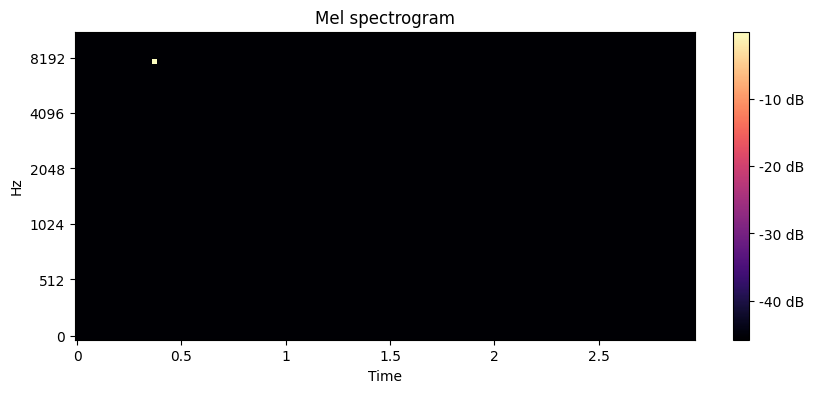

In [27]:
# Display spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(log_spectrogram.T, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.show()


### Saving Specs to images

In [31]:
spec_dir = "../data/spec_images/"

In [32]:
for class_ in classes:
    Path(spec_dir + class_).mkdir(parents=True, exist_ok=True)

In [33]:
len(train_1)

4857

In [ ]:
for index, row in train_1.iterrows(): 

    ytid = row['YTID']
    class_ = row['tags']
    blob = bucket.blob(f"train_{row['YTID']}.wav")
    
    # Check if file already exists
    if os.path.exists(spec_dir + class_ +"/" + ytid + ".png"):
        print(f"File {ytid} already exists, skipping save.")

    else:
        print(f"File {index}: {ytid}, {class_}")

        # Download the audio file to a local file
        file_path = os.path.join('../data/temp_audio', blob.name.split('/')[-1])
        blob.download_to_filename(file_path)

        y, sr = librosa.load(file_path)

        # Compute spectrogram
        spec = np.abs(librosa.stft(y))

        # Convert to decibels
        spec_db = librosa.amplitude_to_db(spec, ref=np.max)


        plt.axis('off')
        plt.axes([0,0,1,1])

        # Plot spectrogram
        librosa.display.specshow(spec_db, sr=sr,cmap='gray')

        # Save as image
        plt.savefig(spec_dir + class_ +"/" + ytid + ".png")

        os.remove(file_path)


File --cB2ZVjpnA already exists, skipping save.
File -0mjrMposBM already exists, skipping save.
File -275_wTLm-4 already exists, skipping save.
File -28U1_qW0sU already exists, skipping save.
File -2hQKCE-oTI already exists, skipping save.
File -3pPrlCm6gg already exists, skipping save.
File -5DdYkYOjy0 already exists, skipping save.
File -64xnyOswXA already exists, skipping save.
File -70wVF5u-gg already exists, skipping save.
File -76P3VHPuus already exists, skipping save.
File -7z662AsuTE already exists, skipping save.
File -82vJ9bcar4 already exists, skipping save.
File -8CrCItCO24 already exists, skipping save.
File -8Ezw9946g8 already exists, skipping save.
File -92cYmTgIjM already exists, skipping save.
File -9ek6eO0RtI already exists, skipping save.
File -9wxcZf43a4 already exists, skipping save.
File -A0MTi2NMGI already exists, skipping save.
File -ASYwidRD7M already exists, skipping save.
File -B3_mFE3pog already exists, skipping save.
File -BxQ9nkrId4 already exists, skippin

File 595: 5_DUQVP5yVM, Source-ambiguous sounds
File 596: 5aC9_oX8dr0, Animal
File 597: 5aCDam9_Ps4, Music
File 598: 5aHvoCScO0g, Sounds of things
File 599: 5anf09_Xzy0, Human Sounds
File 600: 5at69yM1PoU, Music
File 601: 5bRj7cEEZuA, Channel environment and background
File 602: 5bpzZKsNDcg, Animal
File 603: 5bqGY1BoViQ, Animal
File 604: 5bqpcIX2VDQ, Channel environment and background
File 605: 5cbhc17k5bw, Sounds of things
File 606: 5ciRkY7tF6s, Human Sounds
File 607: 5df6pSUSr3o, Human Sounds
File 608: 5dtYx0PUtyg, Sounds of things
File 609: 5fOiSYDYu-Q, Music
File 610: 5go_w4Z-KUo, Channel environment and background
File 611: 5ibYhAoE5HI, Sounds of things
File 612: 5jcOgP-zeTg, Human Sounds
File 613: 5kY6-DsrAk8, Music
File 614: 5m2gMM1rt70, Sounds of things
File 615: 5m2zJ5Wc9MQ, Music
File 616: 5n0xq6pE_mg, Channel environment and background
File 617: 5nLvPfNqUYM, Sounds of things
File 618: 5oHnW1qeStM, Sounds of things
File 619: 5oIP4I0Wkas, Human Sounds
File 620: 5olLmBlOlag, Cha

File 809: 8CW9y10BOwQ, Sounds of things
File 810: 8DU-J83TMfA, Sounds of things
File 811: 8Euw-N5tvPc, Animal
File 812: 8EzO28bSdw0, Sounds of things
File 813: 8Fz3nYhATfQ, Sounds of things
File 814: 8G7yuKhkELs, Human Sounds
File 815: 8HHrlxQuZKE, Music
File 816: 8HXqsTTG2AA, Human Sounds
File 817: 8JPg-X0BOyQ, Music
File 818: 8JWqumczZ-k, Music
File 819: 8JY9zII10CI, Source-ambiguous sounds
File 820: 8JmnE2C3Mqw, Human Sounds
File 821: 8KgtQHbQnDk, Source-ambiguous sounds
File 822: 8LCredoNWN4, Sounds of things
File 823: 8LP3HwjDseA, Source-ambiguous sounds
File 824: 8L_Bg9pScfQ, Sounds of things
File 825: 8N-jlM8tYj8, Human Sounds
File 826: 8NgUtQsMvCk, Source-ambiguous sounds
File 827: 8NwN3DC-r60, Music
File 828: 8OAAfSn43xY, Source-ambiguous sounds
File 829: 8OT-fAXmgOA, Human Sounds
File 830: 8OmRjJJjg8s, Sounds of things
File 831: 8Q3pHpuxZRg, Music
File 832: 8QCcmqaEMPI, Human Sounds
File 833: 8R5EZInmj60, Sounds of things
File 834: 8SYLYWR47EE, Sounds of things
File 835: 8T-E

### Create test/train datasets

In [56]:
X_train = image_dataset_from_directory(
    spec_dir,
    validation_split = 0.2,
    subset = "training",
    seed=7
)

Found 594 files belonging to 7 classes.
Using 476 files for training.


In [ ]:
X_test = image_dataset_from_directory(
    spec_dir,
    validation_split = 0.2,
    subset="validation", 
    seed=7
)

### Deep learning model

In [47]:
model = Sequential([
    
    layers.experimental.preprocessing.Rescaling(1./255,  input_shape=(256, 256, 3)),
    
    layers.Conv2D(32, 7, strides = 4, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    
    layers.MaxPooling2D((4,4)),
    
    layers.Conv2D(128, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),

    layers.Flatten(),
    
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    
    layers.Dense(7, activation='softmax')
])


In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4736      
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)      

In [52]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [54]:
model_history = model.fit(X_train, validation_data=X_test, epochs=40)

Epoch 1/40
15/15 [==============================] - 2s 91ms/step - loss: 6.8079e-04 - accuracy: 1.0000 - val_loss: 2.8943 - val_accuracy: 0.4153
Epoch 2/40
15/15 [==============================] - 2s 87ms/step - loss: 8.0661e-04 - accuracy: 1.0000 - val_loss: 2.8212 - val_accuracy: 0.4153
Epoch 3/40
15/15 [==============================] - 2s 88ms/step - loss: 6.5423e-04 - accuracy: 1.0000 - val_loss: 2.7265 - val_accuracy: 0.4153
Epoch 4/40
15/15 [==============================] - 2s 88ms/step - loss: 6.1441e-04 - accuracy: 1.0000 - val_loss: 2.7373 - val_accuracy: 0.4237
Epoch 5/40
15/15 [==============================] - 2s 89ms/step - loss: 6.0471e-04 - accuracy: 1.0000 - val_loss: 2.7349 - val_accuracy: 0.4492
Epoch 6/40
15/15 [==============================] - 2s 90ms/step - loss: 6.0105e-04 - accuracy: 1.0000 - val_loss: 2.7415 - val_accuracy: 0.4576
Epoch 7/40
15/15 [==============================] - 2s 94ms/step - loss: 6.0293e-04 - accuracy: 1.0000 - val_loss: 2.7241 - val_ac

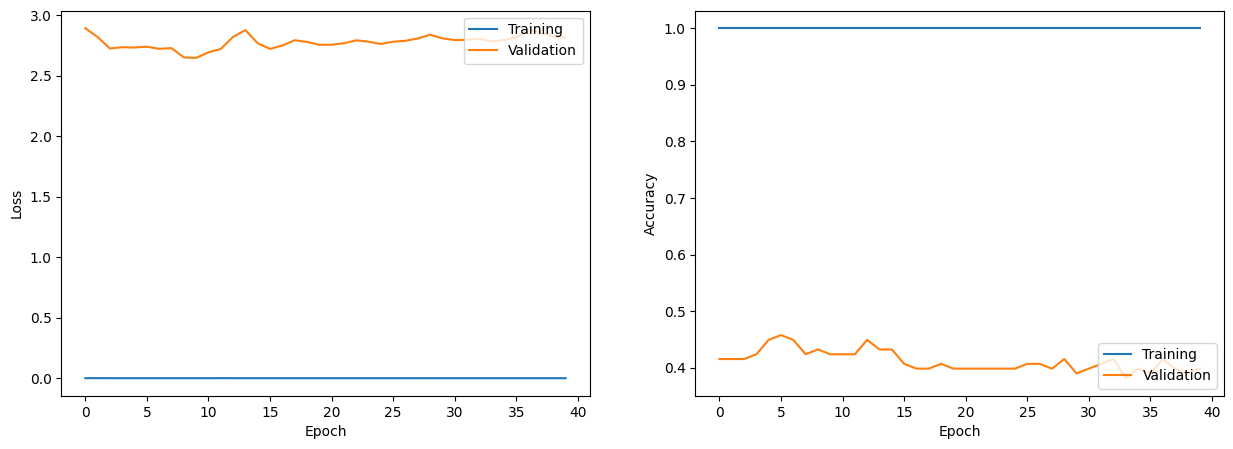

In [55]:
plt.figure(figsize=(15,5))

plt_loss = plt.subplot(121)
plt_loss.plot(model_history.history["loss"])
plt_loss.plot(model_history.history["val_loss"])
# plt.title("")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc="upper right")

plt_accuracy = plt.subplot(122)
plt_accuracy.plot(model_history.history["accuracy"])
plt_accuracy.plot(model_history.history["val_accuracy"])
# plt.title("")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc="lower right")